# Pump it Up: Data Mining the Water Table

### Can you predict which water pumps are faulty?
Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

Competition:
https://www.drivendata.org/competitions/7/

TODO:
- make sure new categories of the test set (not present in the train set) belong to 'Others'
- new column: well age
- new column: funder == installer? (check if this has an effect on status_group)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import sklearn as sk
from sklearn.preprocessing import LabelEncoder

In [2]:
# Download the data and load with pandas
TRAIN_DATA_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv'
TRAIN_LABELS_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv'
TEST_DATA_URL = 'https://s3.amazonaws.com/drivendata/data/7/public/702ddfc5-68cd-4d1d-a0de-f5f566f76d91.csv'

train_values = pd.read_csv(TRAIN_DATA_URL,
                    index_col='id')
train_labels = pd.read_csv(TRAIN_LABELS_URL,
                     index_col='id')
test = pd.read_csv(TEST_DATA_URL,
                   index_col='id')

In [3]:
# merge training values and labels
train = pd.merge(train_values, train_labels, left_index=True, right_index=True)

def status_group_mapper(status_group: str):
    if status_group == 'functional':
        return 2
    elif status_group == 'non functional':
        return 0
    else:
        return 1

# map status_group label to numeric class (0: non-func, 1: repair, 2: func)
train['status_group'] = train['status_group'].apply(status_group_mapper)
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
id,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2


In [4]:
# all object-columns to lower-case
for cname in train.columns:
    if train[cname].dtype == object:
        train[cname] = train[cname].str.lower()

### Explore the dataset

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

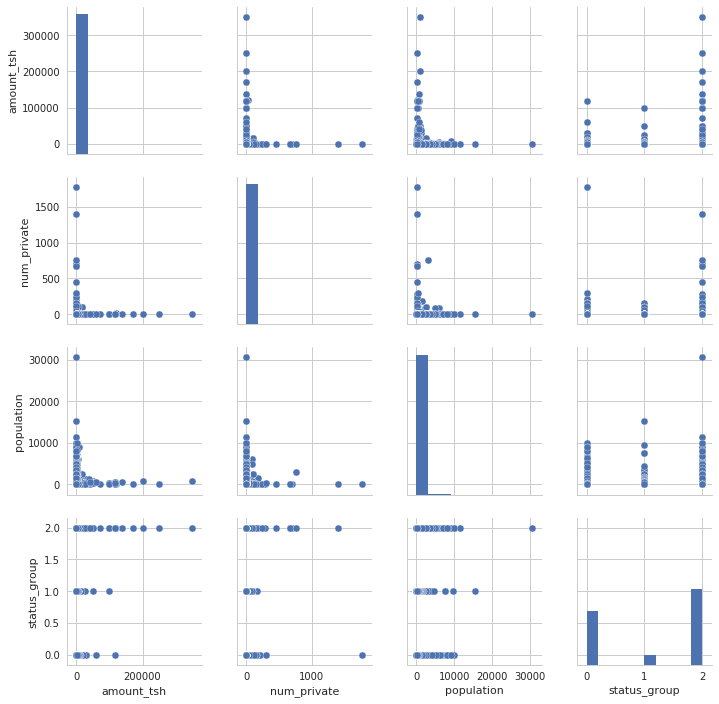

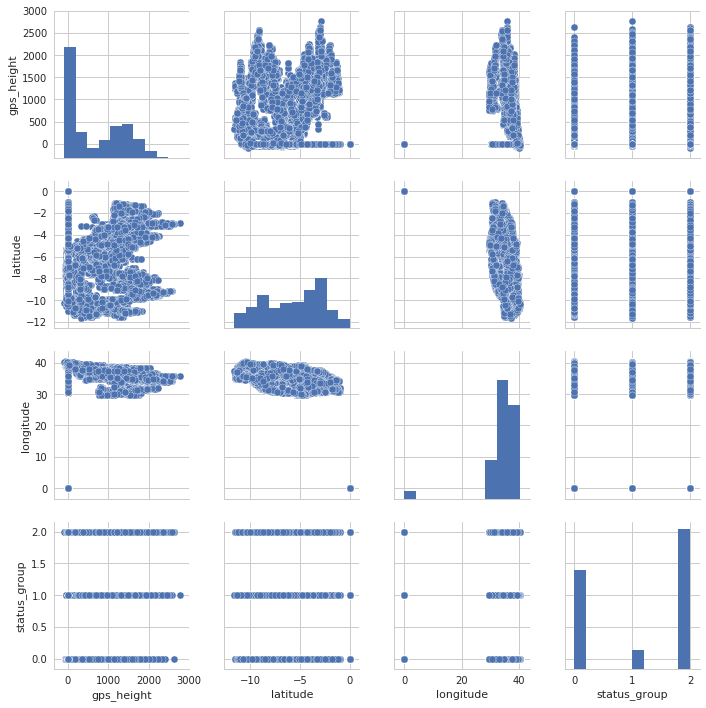

In [20]:
def matrix_plot(cols):
    sns.set(style='whitegrid',context='notebook')
    sns.pairplot(train[cols],size=2.5)
    plt.show()
    
matrix_plot(['amount_tsh','num_private','population','status_group'])

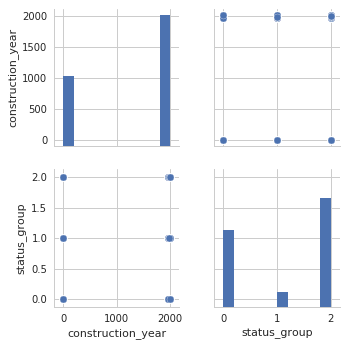

In [22]:
matrix_plot(['gps_height','latitude', 'longitude','status_group'])

In [5]:
# check for missing values
train.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting           59400
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                   59400
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [6]:
def check_redundant(col1, col2):
    result = np.where(train[col1] != train[col2])[0]
    print('{} != {}: {}/{}'.format(col1, col2, result.size, len(train)))

# check redundancies
check_redundant('quantity', 'quantity_group')
check_redundant('waterpoint_type', 'waterpoint_type_group')
check_redundant('water_quality', 'quality_group')
check_redundant('management', 'management_group')
check_redundant('payment', 'payment_type')
check_redundant('source', 'source_type')
check_redundant('source', 'source_class')
check_redundant('extraction_type', 'extraction_type_group')
check_redundant('extraction_type', 'extraction_type_class')
check_redundant('funder', 'installer')

quantity != quantity_group: 0/59400
waterpoint_type != waterpoint_type_group: 6103/59400
water_quality != quality_group: 51664/59400
management != management_group: 56227/59400
payment != payment_type: 24841/59400
source != source_type: 22392/59400
source != source_class: 59334/59400
extraction_type != extraction_type_group: 2469/59400
extraction_type != extraction_type_class: 21426/59400
funder != installer: 40470/59400


### Data preparation

#### quantity, quantity_group

In [7]:
# TODO remove or merge redundant columns
train = train.drop(columns=['quantity_group'])

#### population

In [ ]:
# replace 0 (zero) in columns with NAs
#train = train.replace({'population':0}, np.nan)
# TODO: binning? p<100, 100<p<500, 500<p<1000, 1000<p

#### funder, installer

In [8]:
# replace 0 (zero) in columns with NAs
train = train.drop(columns=['funder'])
train = train.replace({'installer':'0'}, 'other')
train = train.replace({'installer': np.nan}, 'other') # other or unknown?

In [9]:
def replace_mapper(value: str, contains: str, label: str):
    if contains in value:
        return label
    return value

train['installer'] = train['installer'].apply(lambda v : replace_mapper(v, 'gov', 'government'))
train['installer'] = train['installer'].apply(lambda v : replace_mapper(v, 'comm', 'community'))
train['installer'] = train['installer'].apply(lambda v : replace_mapper(v, 'danid', 'danida'))

In [10]:
installer = train['installer'].value_counts()
installer_few = train['installer'].isin(installer.index[installer < 100])
train.loc[installer_few, 'installer'] = 'other'
train['installer'].value_counts()

dwe                              17405
other                            15880
government                        3753
community                         1974
danida                            1676
hesawa                            1395
rwe                               1206
district council                   961
kkkt                               910
tcrs                               707
world vision                       699
ces                                610
amref                              443
lga                                413
tasaf                              411
wedeco                             398
fini water                         389
dmdd                               376
norad                              360
twesa                              316
da                                 308
wu                                 301
acra                               278
sema                               249
dw                                 246
jaica                    

#### waterpoint, waterpoint_type_group

In [11]:
print(train['waterpoint_type'].value_counts(dropna=False))
print(train['waterpoint_type_group'].value_counts(dropna=False))

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64


In [12]:
# make dam (only 7 instances) to others, and drop waterpoint_type_group
train = train.replace({'waterpoint_type':'dam'}, 'other')
train = train.drop(columns=['waterpoint_type_group'])

#### construction_year, date_recorded, well_age

In [32]:
# trim the record date to the year
train['date_recorded'] = train['date_recorded'].apply(lambda v : float(v[:4]))

# fill construction_year==0 with the min value (I expect that the year is unknown because it's a while ago)
train = train.replace({'construction_year':0}, np.nan)
min_construction_year = int(train['construction_year'].min())
train = train.replace({'construction_year':np.nan}, min_construction_year)

# create a new column 'well_age'
train['well_age'] = train['date_recorded'] - train['construction_year']

id
69572    12.0
8776      3.0
34310     4.0
67743    27.0
19728    51.0
9944      2.0
19816    52.0
54551    52.0
53934    52.0
46144    51.0
49056     0.0
50409    26.0
36957    52.0
50495     4.0
53752    52.0
61848    20.0
48451    33.0
58155    33.0
34169    12.0
18274    19.0
48375     3.0
6091     53.0
58500    33.0
37862     2.0
51058     4.0
22308    39.0
55012     2.0
20145    51.0
19685    13.0
69124    11.0
         ... 
14796    53.0
20387    52.0
29940    52.0
15233    25.0
49651    52.0
50998     6.0
34716    23.0
43986    52.0
38067     3.0
58255    51.0
30647    12.0
67885    19.0
47002     5.0
44616     5.0
72148    51.0
34473     1.0
34952     2.0
26640    13.0
72559    18.0
30410     2.0
13677    20.0
44885    46.0
40607    51.0
48348    52.0
11164     4.0
60739    14.0
27263    15.0
37057    51.0
31282    51.0
26348     9.0
Name: well_age, Length: 59400, dtype: float64

#### extraction_type, extraction_type_group, extraction_type_class

#### others

In [ ]:
# inspect categorical columns
train.funder.value_counts(dropna=False)

In [ ]:
train.head()

In [ ]:
encoder = LabelEncoder()
train_quantity_enc = encoder.fit_transform(train['quantity'])
print(encoder.classes_)
train_quantity_enc
# tbd...